## Importing Libraries

In [49]:
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 

## Load and exploring data

In [3]:
df = pd.read_csv('data/tweets.csv',names=['sentiment','id','date','query','user','text'])

In [4]:
df = df.drop(columns=['id','query','date','user'])

## Cleaning data and preparation

In [56]:
df.loc[df['sentiment']==4,'sentiment'] = 1

In [57]:
df['text'] = df['text'].str.lower().replace(f'[{string.punctuation}]','',regex=True)

## Model Building and Training 

In [58]:
x_train, x_test, y_train, y_test = train_test_split(df['text'],df['sentiment'],test_size=0.25)

In [59]:
cntvect = CountVectorizer(stop_words='english')
cntvect.fit(df['text'])

CountVectorizer(stop_words='english')

In [60]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(df['text'])

TfidfVectorizer(stop_words='english')

In [61]:
x_train_vect = cntvect.transform(x_train)
x_test_vect = cntvect.transform(x_test)

In [62]:
x_train_tfidf= tfidf.transform(x_train)
x_test_tfidf= tfidf.transform(x_test)

### Functions 

In [96]:
info_metrics = []
def metrics(model, y_test,predictions):
    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test,predictions,average='weighted')
    recall = recall_score(y_test,predictions,average='weighted')
    f1 = f1_score(y_test,predictions,average='weighted')
    
    info_metrics.append([model, accuracy,precision,recall,f1])

def plot_cm(model, y_test,predictions):
    cm = confusion_matrix(y_test,predictions)
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(model)
    plt.show()

def plot_precision_recall(model,x_test):
    y_scores_model = model.predict_proba(x_test)[:, 1]

    prec_model, recall_model, _ = precision_recall_curve(y_test, y_scores_model)

    auc_model = auc(recall_model, prec_model)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_model, prec_model,label=f'area = { auc_model:.2f}')
    plt.plot([1, 0], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Recall')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

### MultinomialNB with CountVectorizer

In [97]:
mlt = MultinomialNB()
mlt.fit(x_train_vect,y_train)
predictions_1 = mlt.predict(x_test_vect)
metrics('MultinomialNB with CountVectorizer',y_test,predictions_1)

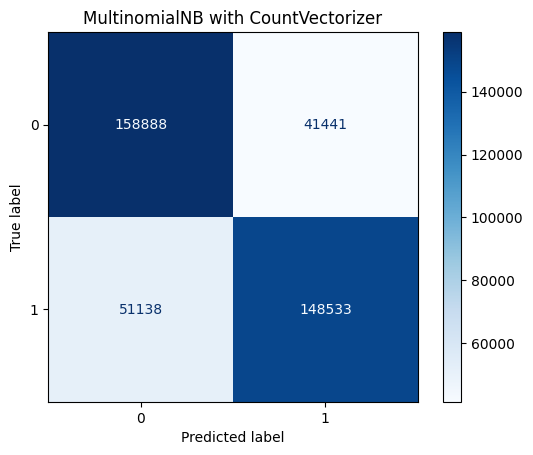

In [98]:
plot_cm('MultinomialNB with CountVectorizer',y_test,predictions_1)

### MultinomialNB with TfidfVectorizer

In [99]:
mlt2 = MultinomialNB()
mlt2.fit(x_train_tfidf,y_train)
predictions_2 = mlt2.predict(x_test_tfidf)
metrics('MultinomialNB with TfidfVectorizer',y_test,predictions_2)

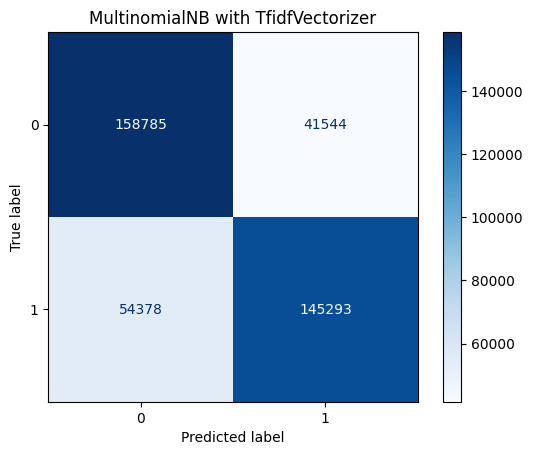

In [100]:
plot_cm('MultinomialNB with TfidfVectorizer',y_test,predictions_2)

### BernoulliNB with CountVectorizer

In [101]:
ber = BernoulliNB()
ber.fit(x_train_vect,y_train)
predictions_3 = ber.predict(x_test_vect)
metrics('BernoulliNB with CountVectorizer',y_test,predictions_3)

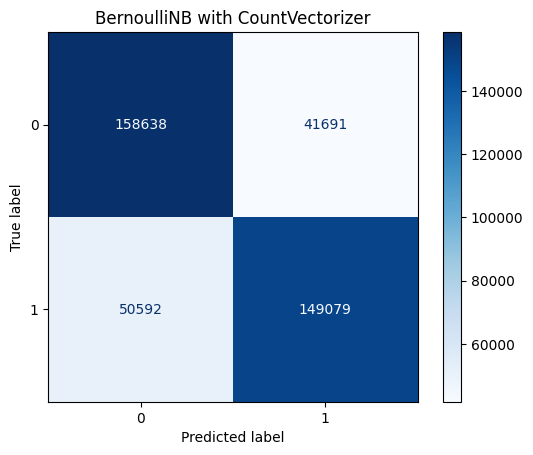

In [102]:
plot_cm('BernoulliNB with CountVectorizer',y_test,predictions_3)

### BernoulliNB with TfidfVectorizer

In [103]:
ber2 = BernoulliNB()
ber2.fit(x_train_tfidf,y_train)
predictions_4 = ber2.predict(x_test_tfidf)
metrics('BernoulliNB with TfidfVectorizer',y_test,predictions_4)

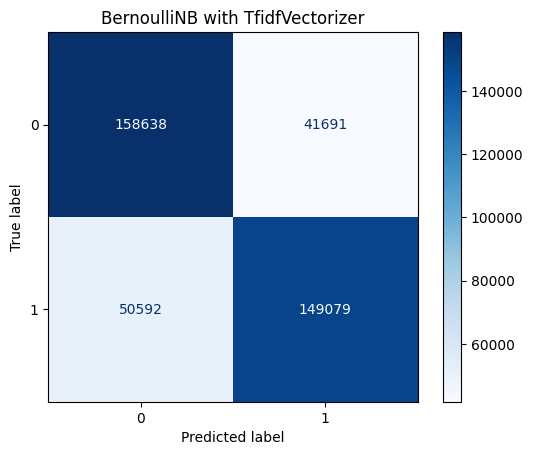

In [104]:
plot_cm('BernoulliNB with TfidfVectorizer',y_test,predictions_4)

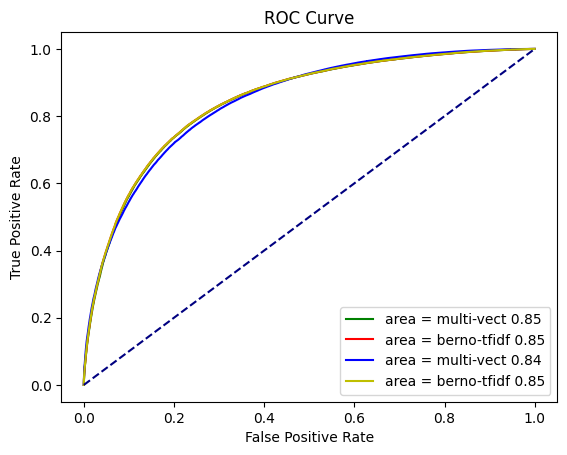

In [107]:
from sklearn.metrics import roc_curve, auc
y_scores_model_1 = mlt.predict_proba(x_test_vect)[:, 1]
y_scores_model_2 = ber.predict_proba(x_test_vect)[:, 1]
y_scores_model_3 = mlt2.predict_proba(x_test_tfidf)[:, 1]
y_scores_model_4 = ber2.predict_proba(x_test_tfidf)[:, 1]

fpr1, tpr1, _ = roc_curve(y_test, y_scores_model_1)
fpr2, tpr2, _ = roc_curve(y_test, y_scores_model_2)
fpr3, tpr3, _ = roc_curve(y_test, y_scores_model_3)
fpr4, tpr4, _ = roc_curve(y_test, y_scores_model_4)

roc_auc_1 = auc(fpr1, tpr1)
roc_auc_2 = auc(fpr2, tpr2)
roc_auc_3 = auc(fpr3, tpr3)
roc_auc_4 = auc(fpr4, tpr4)


plt.figure()
plt.plot(fpr1, tpr1, color='g', label=f'area = multi-vect {roc_auc_1:.2f}')
plt.plot(fpr2, tpr2, color='r', label=f'area = berno-tfidf {roc_auc_2:.2f}')
plt.plot(fpr3, tpr3, color='blue', label=f'area = multi-vect {roc_auc_3:.2f}')
plt.plot(fpr4, tpr4, color='y', label=f'area = berno-tfidf {roc_auc_4:.2f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()


### Results

The BernoulliNB models with CountVectorizer and TfidfVectorizer offer the best performance, with very similar metrics (accuracy, precision, recall and f1 of 0.769), slightly outperforming the MultinomialNB models. The worst performing model is MultinomialNB with TfidfVectorizer, with an accuracy of 0.760.

In [105]:
pd.DataFrame(info_metrics,columns=['model','accuracy','precision','recall','f1']).sort_values(by='accuracy',ascending=False)

,model,accuracy,precision,recall,f1
2,BernoulliNB with CountVectorizer,0.769293,0.769810,0.769293,0.769170
3,BernoulliNB with TfidfVectorizer,0.769293,0.769810,0.769293,0.769170
0,MultinomialNB with CountVectorizer,0.768552,0.769167,0.768552,0.768407
1,MultinomialNB with TfidfVectorizer,0.760195,0.761246,0.760195,0.759935
